# Qamomile v0.9.0

---

This release significantly expands Qamomile's optimization capabilities by introducing support for **Higher-order Unconstrained Binary Optimization (HUBO)** problems through the new `HigherIsingModel` class ([#219](https://github.com/Jij-Inc/Qamomile/pull/219)). Building on this foundation, QAOA can now handle HUBO problems using phase-gadget techniques ([#221](https://github.com/Jij-Inc/Qamomile/pull/221)), enabling quantum algorithms to solve a broader class of optimization problems beyond traditional QUBO formulations.

We have also added comprehensive CUDA-Q tutorials. Please have a look at our [releases](https://github.com/Jij-Inc/Qamomile/releases) and individual PRs for more details.

## ✨ New Features

### Introduce `HigherIsingModel` ([#219](https://github.com/Jij-Inc/Qamomile/pull/219) and [#225](https://github.com/Jij-Inc/Qamomile/pull/225))

The `HigherIsingModel` class brings support for **Higher-order Unconstrained Binary Optimization (HUBO)** problems to Qamomile. While traditional QUBO problems are limited to quadratic terms, HUBO problems can include interactions of arbitrary order (e.g., cubic, quartic, or higher), making them applicable to a wider range of optimization scenarios.

Key features of `HigherIsingModel`:

- **Arbitrary Order Terms**: Supports Ising models with terms of any degree, not just linear and quadratic
- **Unified Interface**: The existing `IsingModel` class is now a subclass of `HigherIsingModel`, providing backward compatibility while extending functionality
- **Automatic Index Management**: Handles index mapping and re-indexing internally, converting user-provided indices to zero-origin continuous indices for efficient quantum algorithm execution

The mathematical formulation of a higher-order Ising model:

$$
H = C + \sum_i w_i Z_i + \cdots + \sum_{i_0, \dots, i_k} w_{i_0, \dots, i_k} Z_{i_0}\dots Z_{i_k}
$$

where $Z_i \in \{-1, +1\}$ and $w$ represents interaction strengths.

In [ ]:
from qamomile.core.ising_qubo import IsingModel
from qamomile.core.higher_ising_model import HigherIsingModel

# Create a HigherIsingModel with cubic terms
higher_coefficients = {
    (0, 2): -1.5,        # Quadratic term
    (1, 2): 0.5,         # Quadratic term
    (0, 1, 2): 2.0,      # Cubic term (higher-order!)
    (0,): -2.0,          # Linear term
}
constant = 1.0
higher_ising_model = HigherIsingModel(higher_coefficients, constant=constant)

print("HigherIsingModel with cubic terms:")
print(f"Coefficients: {higher_ising_model.coefficients}")
print(f"Constant: {higher_ising_model.constant}")
print(f"Number of variables: {higher_ising_model.num_bits}")

# IsingModel is now a subclass of HigherIsingModel, providing backward compatibility
quadratic_coefficients = {(0, 1): -0.5}
linear_coefficients = {0: -1.0, 1: 2.0}
ising_model = IsingModel(linear=linear_coefficients, quad=quadratic_coefficients, constant=1.0)

print("\nIsingModel (subclass of HigherIsingModel):")
print(f"Has coefficients attribute: {hasattr(ising_model, 'coefficients')}")
print(f"Coefficients: {ising_model.coefficients}")
print(f"Linear: {ising_model.linear}")
print(f"Quadratic: {ising_model.quad}")

HigherIsingModel with cubic terms:
Coefficients: {(0, 2): -1.5, (1, 2): 0.5, (0, 1, 2): 2.0, (0,): -2.0}
Constant: 1.0
Number of variables: 3

IsingModel (subclass of HigherIsingModel):
Has coefficients attribute: True
Coefficients: {(0, 1): -0.5, (0,): -1.0, (1,): 2.0}
Linear: {0: -1.0, 1: 2.0}
Quadratic: {(0, 1): -0.5}


### Update `QAOAConverter` to handle HUBO problems ([#221](https://github.com/Jij-Inc/Qamomile/pull/221))

Building on the `HigherIsingModel` foundation, QAOA can now solve HUBO problems through the use of **phase-gadget** techniques. Phase-gadgets are quantum circuit constructions that enable the efficient encoding of higher-order terms into quantum circuits suitable for QAOA execution.

**What are Phase-Gadgets?**

Phase-gadgets are specialized quantum circuits that implement multi-qubit controlled rotations. For a higher-order term like $Z_i Z_j Z_k$, a phase-gadget circuit implements the corresponding phase rotation using CNOT gates and an RZ gate.

**Key Updates:**

- **Automatic HUBO Detection**: `QAOAConverter` now automatically detects whether a problem is QUBO or HUBO
- **Phase-Gadget Integration**: Higher-order terms are automatically converted to phase-gadget circuits
- **Seamless User Experience**: The same `QAOAConverter` API works for both QUBO and HUBO problems

**Technical Details:**

When `ising_encode()` is called on a HUBO instance, the converter:
1. Detects higher-order terms in the problem
2. Creates a `HigherIsingModel` instead of the traditional `IsingModel`
3. Generates phase-gadget circuits for each higher-order term during the QAOA ansatz construction
4. Combines these with standard QAOA mixer and problem layers

Problem type: HUBO
Ising model type: HigherIsingModel
Supports HUBO: True


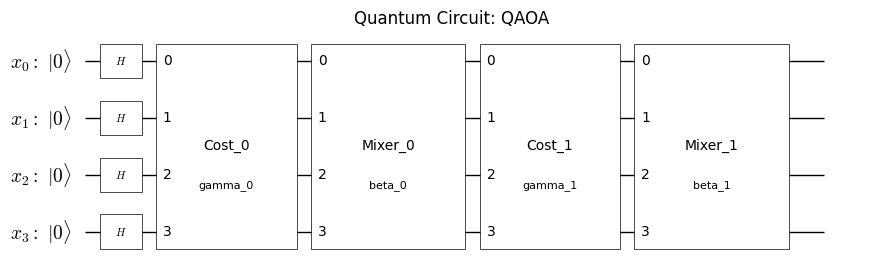

In [ ]:
import jijmodeling as jm

from qamomile.core.converters.qaoa import QAOAConverter
from qamomile.core.circuit.drawer import plot_quantum_circuit

# Define a simple HUBO problem using JijModeling
# This example creates a problem with an N-body problem.
N = jm.Placeholder('N')
x = jm.BinaryVar('x',shape=(N,))
i = jm.Element('i', belong_to=(0, N))
problem = jm.Problem('N-body problem')
problem += jm.prod(i, x[i])
problem += jm.sum(i, x[i])

# Compile to OMMX instance
instance_data = {"N": 4}
interpreter = jm.Interpreter(instance_data)
instance= interpreter.eval_problem(problem)

# Convert to QAOA - now supports HUBO!
qaoa_converter = QAOAConverter(instance)
qaoa_converter.ising_encode()  # Automatically detects HUBO and uses HigherIsingModel

print(f"Problem type: {'HUBO' if not qaoa_converter.is_qubo else 'QUBO'}")
print(f"Ising model type: {type(qaoa_converter.get_ising()).__name__}")
print(f"Supports HUBO: {qaoa_converter._hubo_support}")

# Get QAOA circuit - phase-gadgets are automatically included in the cost layers
p = 2
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)
plot_quantum_circuit(qaoa_circuit)

## 🐛 Bug Fixes

- **Fixed decoding errors** ([#225](https://github.com/Jij-Inc/Qamomile/pull/225), [#218](https://github.com/Jij-Inc/Qamomile/issues/218)): Resolved issues with bit-to-solution decoding in quantum converters, improving the accuracy of result interpretation
- **Index mapping improvements** ([#214](https://github.com/Jij-Inc/Qamomile/issues/214)): Enhanced index management in `HigherIsingModel` to ensure correct mapping between problem variables and quantum bits

See our [releases](https://github.com/Jij-Inc/Qamomile/releases) for more details.

## 🛠️ Other Changes and Improvements

- **CUDA-Q Tutorial** ([#212](https://github.com/Jij-Inc/Qamomile/pull/212)): Added comprehensive English and Japanese tutorials for using Qamomile with CUDA-Q, NVIDIA's quantum computing platform. Check out the [CUDA-Q usage tutorial](https://jij-inc.github.io/Qamomile/en/tutorial/usage/cudaq_transpiler_usage.html) to get started!

See our [releases](https://github.com/Jij-Inc/Qamomile/releases) for more details.

## 💬 Feedback

With the introduction of HUBO support through `HigherIsingModel` and phase-gadget techniques in QAOA, Qamomile v0.9.0 significantly expands the scope of optimization problems that can be tackled with quantum algorithms. This release makes Qamomile an even more powerful and versatile tool for quantum optimization research and development.

Whether you're working on traditional QUBO problems or exploring higher-order optimization challenges, Qamomile provides a unified interface to access multiple quantum SDKs and compare results with classical solvers.

Try out Qamomile v0.9.0 today! Please submit any feedback or bug reports to [GitHub Issues](https://github.com/Jij-Inc/Qamomile/issues).